In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylab import rcParams
from matplotlib import cm
import os
import stumpy
from scipy import interpolate
from scipy.cluster.hierarchy import linkage, dendrogram

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# Discovering motifs under uniform scaling
This tutorial explores the "Discovering motifs under uniform scaling" case study from the research paper:  
[The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do with the Matrix Profile and Ten Lines of Code (see Section 3.1)"](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf).

## 1. First consideration of uniform-scaling invariance (Yankov 2007)

### 1-1. Introduction
Time series motifs are approximately repeated patterns found within the data.  For many data mining areas the  
detection of such repeated patterns is of essential importance.  
Here, we show that the existing approaches for motif detection are limited to discovering pattern occurrences of the same length,  
failing to capture similarities **when the occurrences are uniformly scaled along the time axis**.  

We will examine a synthetic time series (synthetic data is used here for ease of exposition).

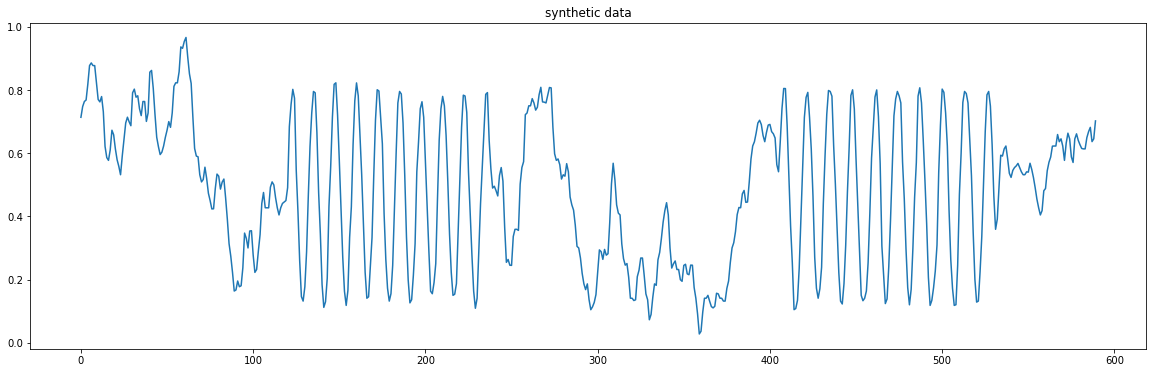

In [3]:
T = pd.read_pickle("dataset/31_1_yankov1.pkl")
plt.plot(T)
plt.title("synthetic data")
plt.show()

**Here is a time series of length 600. What is the best motif of length 120?**  
If we are asked to point out the best repeated pattern of length 120, the answer appears trivial:  
there is an obvious repeated sine wave of approximate length 120 in two locations.

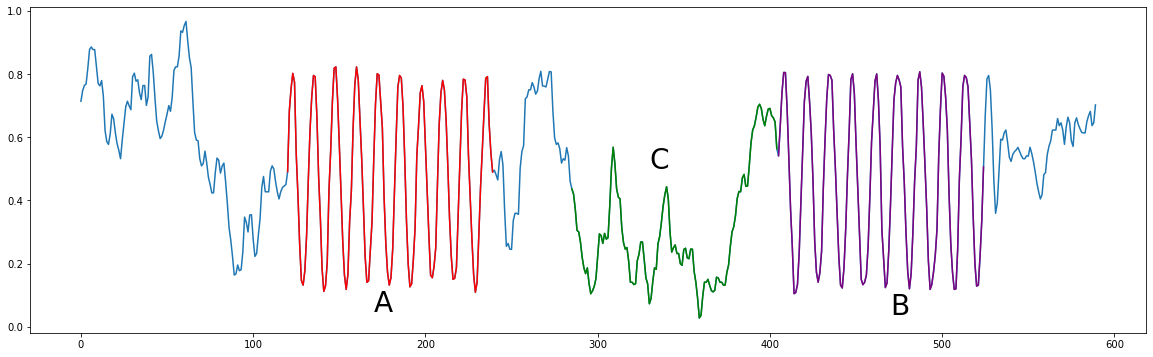

In [4]:
x = np.array(range(len(T)))
m = 120
idx_a, idx_b, idx_c = 120, 405, 285

plt.plot(T)
plt.plot(x[idx_a:idx_a+m], T[idx_a:idx_a+m], color="red")
plt.plot(x[idx_b:idx_b+m], T[idx_b:idx_b+m], color="purple")
plt.plot(x[idx_c:idx_c+m], T[idx_c:idx_c+m], color="green")
plt.text(170, 0.05, "A", fontsize=28)
plt.text(470, 0.04, "B", fontsize=28)
plt.text(330, 0.5, "C", fontsize=28)
plt.show()

Let's calculate the pair-wise euclidean distance between the three patterns A, B, and C.  
It looks A and B are almost identical, but the cumulative error
of the out-of-phase sections will tend to dominate.  
In Euclidean distance, A is closer C than B as a result. Because they have many peaks and valleys with different linear scaling. It causes a large Euclidean distance.

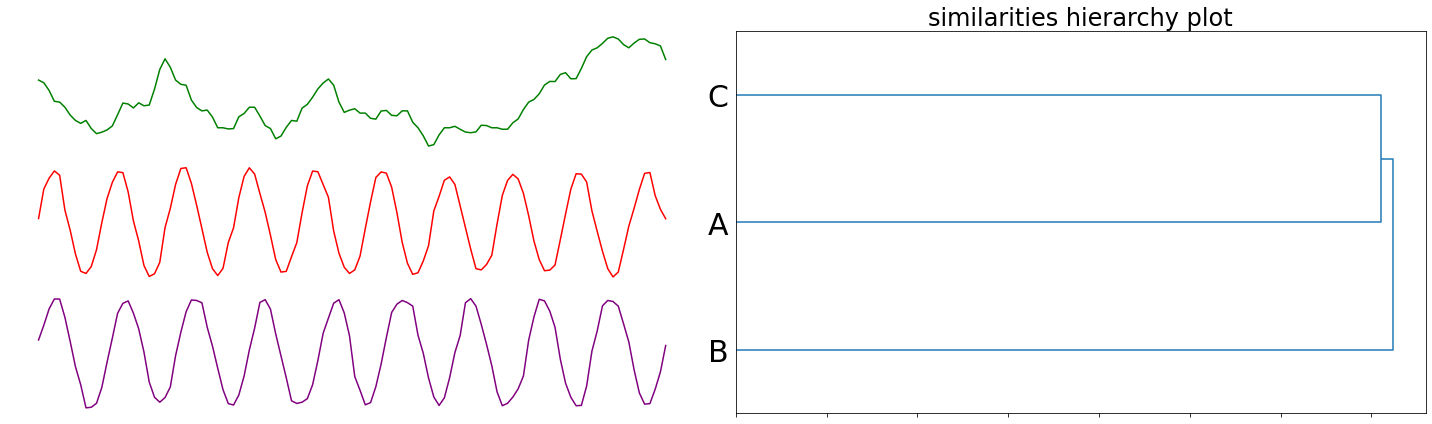

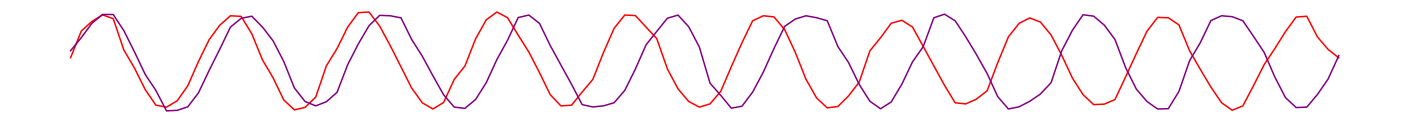

In [5]:
def distance(x, y):
    return np.linalg.norm(x-y)

S_a, S_b, S_c= T[idx_a:idx_a+m], T[idx_b:idx_b+m], T[idx_c:idx_c+m]

t_ = np.vstack([S_a, S_b, S_c])
D = linkage(t_, method='single', metric=distance)

plt.subplot(122)
plt.title("similarities hierarchy plot", fontsize=24)
plt.tick_params(labelbottom=False)
dendrogram(D, leaf_font_size=30, orientation="right", labels=["A", "B", "C"])

for (coo_, S_, color_) in zip([321, 323, 325], [S_c, S_a, S_b], ["green", "red", "purple"]):
    plt.subplot(coo_)
    plt.plot(S_, color=color_)
    plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 2))
plt.plot(S_a, color="red")
plt.plot(S_b, color="purple")
plt.axis("off")
plt.show()


### 1-2. Existing tech is effective ? (Details on original paper)

1.Why not replace the Euclidean distance with the Dynamic
Time Warping (DTW) distance?  
 => DTW is no more useful than Euclidean distance in this case.

2.Why not search for shorter patterns, and after finding
the shorter motifs, somehow “grow” them with invariance
to uniform scaling?  
 => the idea of “growing” motifs (under invariance to “noise”) appears unworkable
in both real and discrete domains.

### 1-3. Optimal squared Euclidean distance (uniform scaling)
Suppose that we have a query time series $Q = (q_1, q_2,.....,q_{m_q})$ Suppose that we have a query time series $C = (c_1, c_2,.....,c_{m_c})$.  

Without loss of generality, assume that $m_q \leq m_c$, $s$ is scaled time series length.  
A uniformly scaled version of the query $Q$ with scaling factor $\frac {m_q}{s}$ is the time series $Q^s = (q ^{s}_{1}, q ^{s}_{1},.....,q ^{s}_{s})$, where $q ^{s}_{i} = q_{i \frac {m_q}{s}}$.  

Comparing $Q$ and $C$ directly.  
Left plot: yields larger Euclidean distance.  
Right plot: stretching Q with 8% produces $Q_s$ which resembles very closely the prefix of $C$.

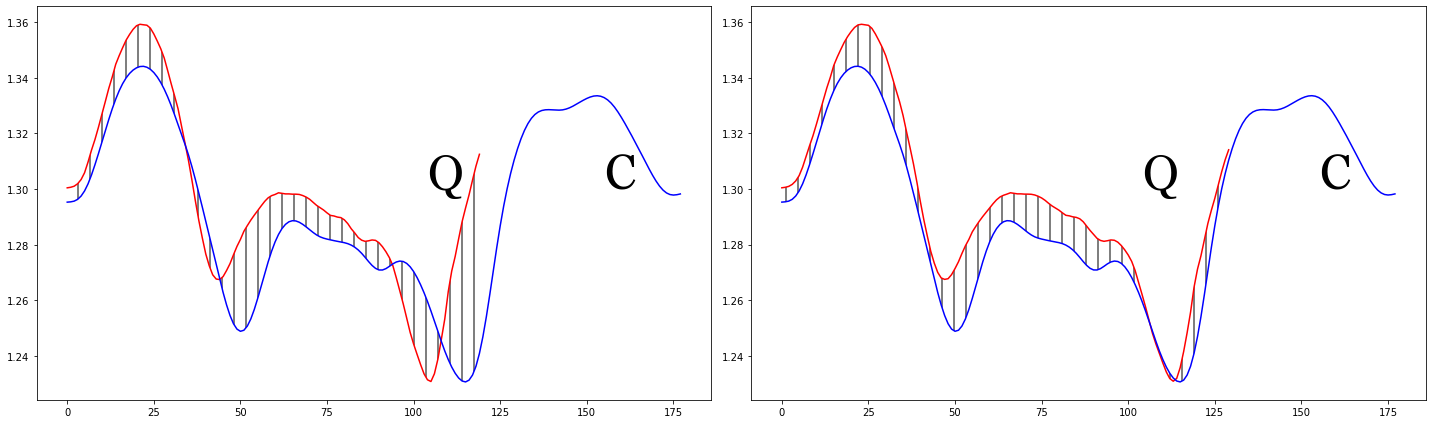

In [6]:
query_red = pd.read_pickle("dataset/31_1_yankov2_red.pkl")
cand_blue = pd.read_pickle("dataset/31_1_yankov2_blue.pkl")
x_red = np.arange(len(query_red))
cand_blue_ = cand_blue[:len(query_red)]

# uniform scaling
fitted_curve = interpolate.PchipInterpolator(x_red, query_red)
x_dummy = np.arange(0, len(query_red), 1/1.08)

query_red_s = fitted_curve(x_dummy)
x_red_s = np.arange(len(query_red_s))
cand_blue_s = cand_blue[:len(query_red_s)]

# plot
_, axes = plt.subplots(1, 2, tight_layout=True)
fontd_ = {"family" : "Georgia"}

axes[0].plot(query_red, color="red")
axes[0].plot(cand_blue, color="blue")
axes[0].fill_between(x_red, query_red, cand_blue_,
                facecolor='white', hatch="|", interpolate=True)
axes[0].text(104, 1.30, "Q", fontsize=48, fontdict=fontd_)
axes[0].text(155, 1.30, "C", fontsize=48, fontdict=fontd_)

axes[1].plot(query_red_s, color="red")
axes[1].plot(cand_blue, color="blue")
axes[1].fill_between(x_red_s, query_red_s, cand_blue_s,
                facecolor='white', hatch="|", interpolate=True)
axes[1].text(104, 1.30, "Q", fontsize=48, fontdict=fontd_)
axes[1].text(155, 1.30, "C", fontsize=48, fontdict=fontd_)
plt.show()


The uniform scaling distance  $d_{u}(Q, C)$ is defined as optimal squared Euclidean distance between some prefix of $C$ with length $s >= m_{q}$  
and query scaled to the size of that prefix. Or more formally:

\begin{align}  
    d_{u}(Q, C) ={}&
        \min _{m_{q} \leq {s} \leq m_{c}}{
            \sum_{i=1}^{s} ( q^s_{i} - c_{i})^2
        }
\end{align}

## 2. Uniform scaling

A random walk time series with two exemplars from the MALLAT dataset.  
Let's demonstrate how unifrom scaling can affect its similarity.

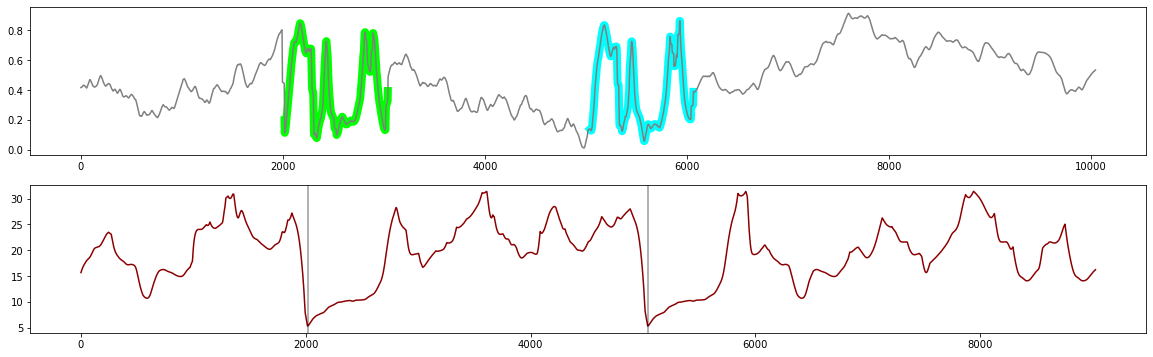

In [7]:
data = pd.read_pickle("dataset/31_1_MALLAT.pkl")
strech_div = 5000
strech_ratio = 1.06
m = 1024

x_raw = np.arange(len(data))
mp_raw = stumpy.stump(data, m)
idx_a_raw = np.argmin(mp_raw[:, 0])
idx_b_raw = mp_raw[:, 1][idx_a_raw]

fig, axs = plt.subplots(2, 1)
axs[0].plot(x_raw[idx_a_raw:idx_a_raw+m], data[idx_a_raw:idx_a_raw+m],
            color="lime", linewidth=8)
axs[0].plot(x_raw[idx_b_raw:idx_b_raw+m], data[idx_b_raw:idx_b_raw+m],
            color="aqua", linewidth=8)
axs[0].plot(data, color="gray")
axs[1].plot(mp_raw[:, 0], color="darkred")
axs[1].axvline(idx_a_raw, color="k", alpha=0.4)
axs[1].axvline(idx_b_raw, color="k", alpha=0.4)
plt.show()

**Top plot**: The color highlighting indicates the top-1 motif  
**Bottom plot**: The matrix profile corresponding to the random walk time series.  
The minimum values (grey line) correspond to the top-1 motif in the time series.  

The same time series, with the second half linearly stretched by 6%.  
How does top-1 motif change?

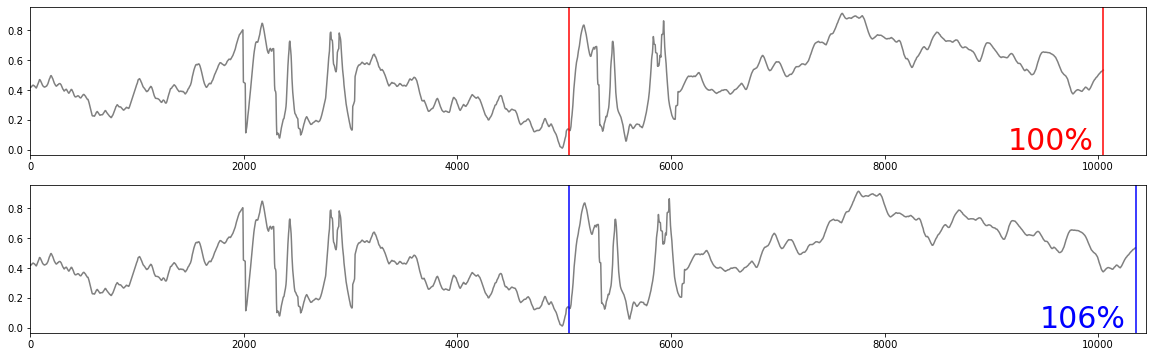

In [8]:
data_sepA = data[:-strech_div]
data_sepB = data[-strech_div:]

x_B = np.arange(len(data_sepB))
fitted_curve = interpolate.PchipInterpolator(x_B, data_sepB)
x_dummy = np.arange(0, len(x_B), 1/strech_ratio)
data_sepB_s = fitted_curve(x_dummy)
data_streched = np.hstack([data_sepA, data_sepB_s])

fig, axs = plt.subplots(2, 1)
axs[0].plot(data, color="gray")
axs[0].axvline(len(data)-strech_div, color="red")
axs[0].axvline(len(data), color="red")
axs[0].text(len(data)-900, 0, "100%", color="red", fontsize=30)
axs[0].set_xlim(0, len(data_streched)+100)
axs[1].plot(data_streched, color="gray")
axs[1].axvline(len(data_streched)-strech_div*strech_ratio, color="blue")
axs[1].axvline(len(data_streched), color="blue")
axs[1].text(len(data_streched)-900, 0, "106%", color="blue", fontsize=30)
axs[1].set_xlim(0, len(data_streched)+100)
plt.show()

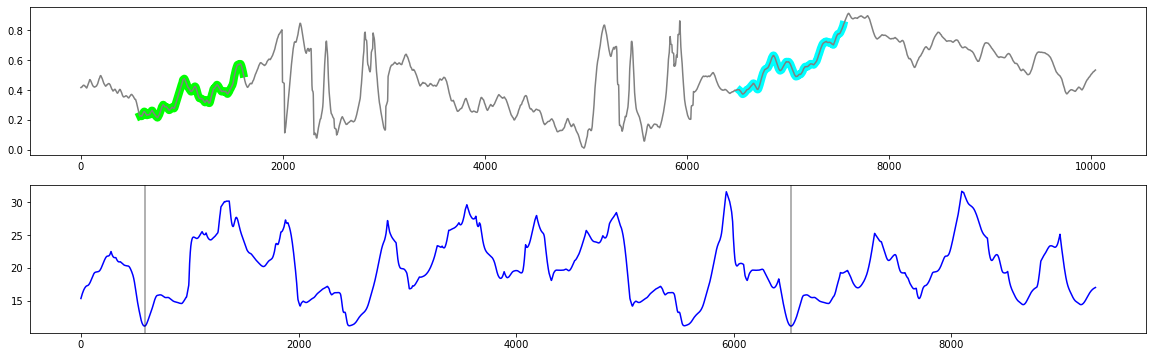

In [9]:
mp_strech = stumpy.stump(data_streched, m)
x_s = np.arange(len(data_streched))

idx_a_s = np.argmin(mp_strech[:, 0])
idx_b_s = mp_strech[:, 1][idx_a_s]

fig, axs = plt.subplots(2, 1)
axs[0].plot(x_s[idx_a_s:idx_a_s+m], data[idx_a_s:idx_a_s+m],
            color="lime", linewidth=8)
axs[0].plot(x_s[idx_b_s:idx_b_s+m], data[idx_b_s:idx_b_s+m],
            color="aqua", linewidth=8)
axs[0].plot(data, color="gray")
axs[1].plot(mp_strech[:, 0], color="b")
axs[1].axvline(idx_a_s, color="k", alpha=0.4)
axs[1].axvline(idx_b_s, color="k", alpha=0.4)
plt.show()

## 3. Which kind of dataset is effective?
Time seris with **very sharp rises and falls** are particularly sensitive to having features out of phase like complex time series.  
For most datasets, motif discovery is much more robust to small amounts of uniform scaling.  

Here is one of the class of **OSU Leaf** dataset(complex time series) in [UCR Time Series Classification Archive](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/)
.

The pair of raw dataset are no longer the top-1 motif, an unexpected and disquieting result.

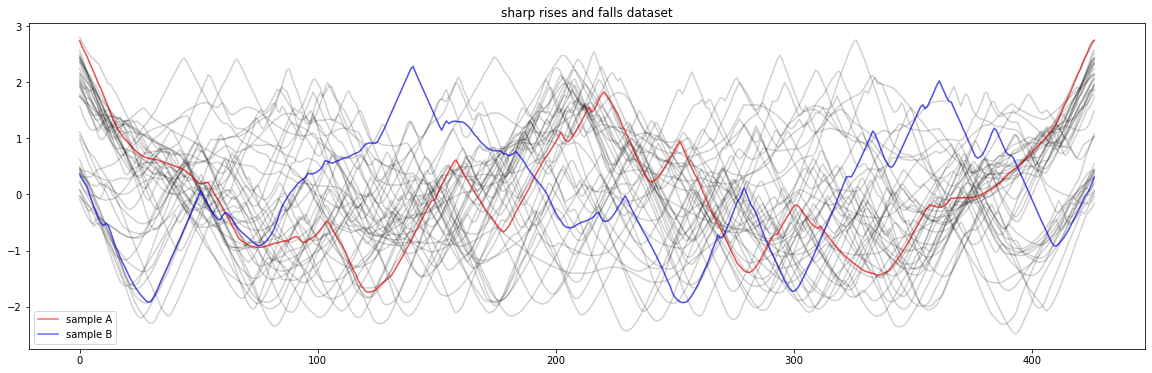

In [37]:
leaf = pd.read_csv("dataset/OSULeaf_TEST", header=None)
mask_class4 = leaf.iloc[:, 0] == 4
leaf_class4 = leaf.loc[mask_class4, :]
plt.plot(leaf_class4.values[:, 1:].T, color="k", alpha=0.18)
plt.plot(leaf_class4.values[1, 1:].T, color="red", alpha=0.6, label="sample A")
plt.plot(leaf_class4.values[3, 1:].T, color="blue", alpha=0.6, label="sample B")
plt.legend()
plt.title("sharp rises and falls dataset")
plt.show()

## 4. Search scaling factor with Matrix profile
Two non-contagious snippets from the ElectriSense dataset is household electrical demand (Gupta 2010).  
**Green Line** : The January 14th pattern  
**Red Line** : The January 18th pattern

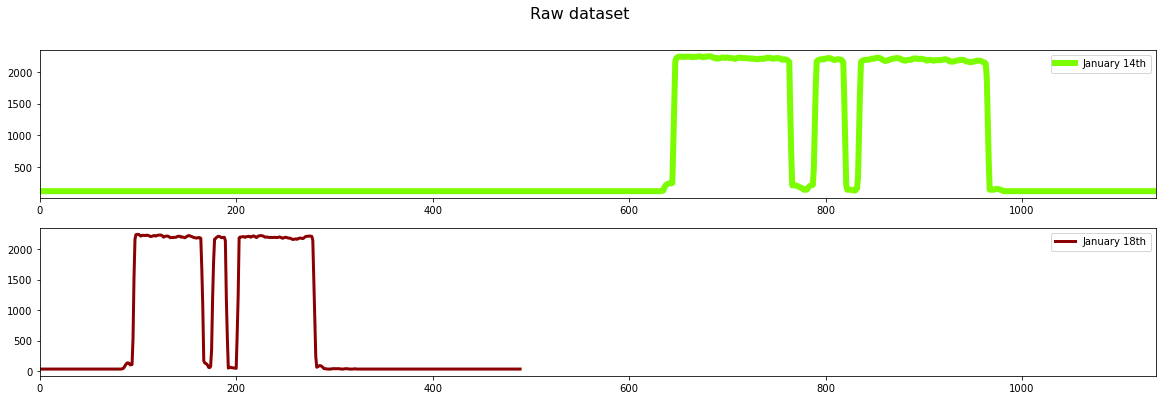

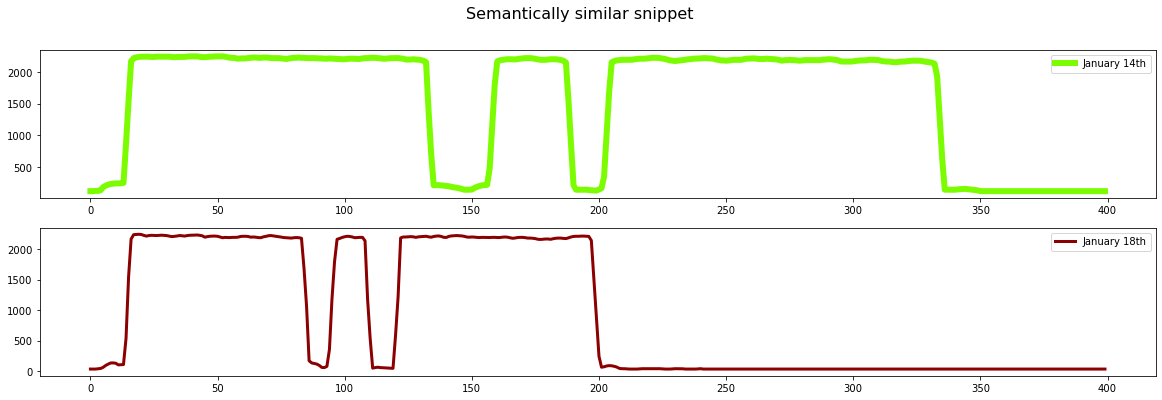

In [34]:
electric_14 = pd.read_pickle("dataset/31_4_green.pkl")
electric_18 = pd.read_pickle("dataset/31_4_red.pkl")
x_14 = np.arange(len(electric_14))

# catch rising edge for comparing briefly
def brief_edge(x): return np.where(x>1000)[0][0] - 15
idx_edge14 = brief_edge(electric_14)
idx_edge18 = brief_edge(electric_18)

fig1, axs1 = plt.subplots(2, 1)
fig2, axs2 = plt.subplots(2, 1)
fig1.suptitle("Raw dataset", fontsize=16)
axs1[0].plot(electric_14, color="lawngreen", linewidth=6, label="January 14th")
axs1[0].set_xlim(0, len(electric_14))
axs1[0].legend()
axs1[1].plot(electric_18, color="darkred", linewidth=3, label="January 18th")
axs1[1].set_xlim(0, len(electric_14))
axs1[1].legend()

fig2.suptitle("Semantically similar snippet", fontsize=16)
axs2[0].plot(electric_14[idx_edge14:idx_edge14+400], color="lawngreen", linewidth=6, label="January 14th")
axs2[0].legend()
axs2[1].plot(electric_18[idx_edge18:idx_edge18+400], color="darkred", linewidth=3, label="January 18th")
axs2[1].legend()
plt.show()

While semantically similar, they have a very large Euclidian distance because they are of different lengths.

To the best of our knowledge, there is only one research effort that has addressed this. However, this method is approximate, requires many parameters to be set,  
and is only able to support a limited range of scaling (Yankov 2007).  In contrast, we can easily and exactly solve this problem under our simple assumptions.

Given our assumptions, we can simply iterate over all possible scaling factors in a given range.  
For example, to discover motifs that are similar after scaling one pattern by 150–180%, we can use the following code snippet.

In [18]:
T_A, T_B = electric_14, electric_18

m = 500
l = len(T_A) - m + 1

P_updated = np.full(l, np.inf, dtype=np.float64)
I_updated = np.zeros(l, dtype=np.float64)
minScale = np.ones(l, dtype=np.float64)

x_Tb = np.arange(len(T_B))
fitted_curve = interpolate.PchipInterpolator(x_Tb, T_B)  # strech function

for scale_factor in range(150, 180):
    stretch_scale = 100 / scale_factor
    x_dummy = np.arange(0, len(x_Tb), stretch_scale)
    T_B_stretched = fitted_curve(x_dummy)
    mp = stumpy.stump(T_A, m, T_B_stretched, ignore_trivial=False, normalize=False)
    mask = mp[:, 0] < P_updated
    P_updated[mask] = mp[mask, 0]
    I_updated[mask] = mp[mask, 1]
    minScale[mask] = stretch_scale


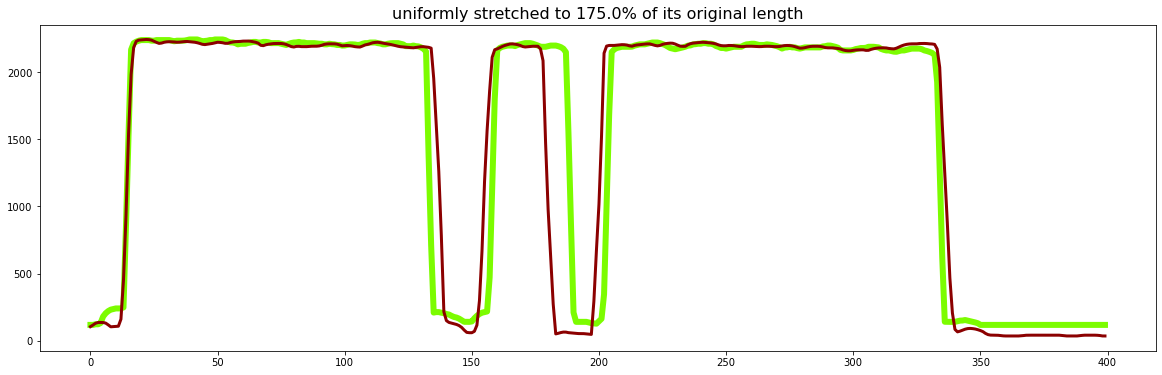

In [36]:
idx_fit = np.argmin(P_updated)
scale_fit = minScale[idx_fit]
fitted_curve = interpolate.PchipInterpolator(x_Tb, T_B)
x_dummy = np.arange(0, len(x_Tb), scale_fit)
T_B_stretched = fitted_curve(x_dummy)

idx_Ta = brief_edge(T_A)
idx_Tbs = brief_edge(T_B_stretched)

plt.plot(T_A[idx_Ta:idx_Ta+400], color="lawngreen", linewidth=6)
plt.plot(T_B_stretched[idx_Tbs:idx_Tbs+400], color="darkred", linewidth=3)
plt.title(f"uniformly stretched to {100/scale_fit}% of its original length", fontsize=16)
plt.show()

Now, the resulting Matrix Profile will discover the motifs with the appropriate uniform scaling invariance.  
In fact, we did exactly this on a 6,106,456 length trace of household electrical demand to discover the motif shown.  

This example perfectly elucidates the philosophy driving this paper.  
For many time series data mining tasks, we may not need to spend significant human time
designing, implementing and tuning new algorithms.  
The Matrix Profile and ten lines of code may be sufficient.

## References
[The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do With The Matrix Profile And Ten Lines Of Code](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf) (see Section 3.1)

Yankov 2007: [Detecting time series motifs under uniform scaling. In: Proceedings of the 2007 ACM SIGKDD](https://dl.acm.org/doi/10.1145/1281192.1281282)  

OSU Leaf: [UCR Time Series Classification Archive](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/)

Gupta 2010: [ElectriSense: single-point sensing using EMI for electrical event detection and classification in the home](https://ubicomplab.cs.washington.edu/publications/electrisense/)